https://www.aprendemachinelearning.com/clasificacion-de-imagenes-en-python/

https://towardsdatascience.com/image-generation-in-10-minutes-with-generative-adversarial-networks-c2afc56bfa3b

machine learning generate images based on text

la idea del baseline es tener un modelo choto, para que cuando lo mejore tenga algo para comparar.

es hacer algo muy rápido y barato de hacer. La idea es minimizar el esfuerzo

* batchsize, ponerlo lo más grande posible
* que es dropout 
* que es el early stoping (usar siempre) redes neuronales


## Importacion y dataframe

###Drive

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#procesar imagenes
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, drive
from oauth2client.client import GoogleCredentials

drive.mount('/content/gdrive')

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


Mounted at /content/gdrive


https://towardsdatascience.com/how-to-successfully-add-large-data-sets-to-google-drive-130beb320f1a


In [4]:
#@title zip y unzip
# !unzip "/content/gdrive/MyDrive/Organización de Datos/TPS/TP4/Datos/silkroad2_images.zip" -d "/content/gdrive/MyDrive/Organización de Datos/TPS/TP4/Datos"

#-d creates the directory and extracted files are stored there.



# direccion = "Organización de Datos/TPS/TP4/Datos/"
# !unzip ("/content/gdrive/MyDrive/"+direccion+"/test 9 imagenes.zip") -d ("/content/gdrive/MyDrive/"+direccion+"/unziped")
#https://colab.research.google.com/github/sudo-ken/compress-decompress-in-Google-Drive/blob/master/Unrar_Unzip_Rar_Zip_in_GDrive.ipynb#scrollTo=VKdYIG49VaYA



# from zipfile import ZipFile
# with ZipFile("/content/gdrive/MyDrive/Organización de Datos/TPS/TP4/Datos/test 9 imagenes.zip", "r") as archivo:
#   archivo.extractall("/content/gdrive/MyDrive/Organización de Datos/TPS/TP4/Datos/unziped")

#https://www.kaggle.com/mchirico/how-to-read-datasets

In [5]:
downloaded = drive.CreateFile({'id': '1FYEJ8QxvNzDF55EfE9gy_pMEmHftky4_'})
downloaded.GetContentFile('silkroad_items.csv')

items=pd.read_csv('silkroad_items.csv')

In [6]:
#solo conservar items que tengan una imagen asociada
items = items[items['image_id'].notnull()]

###Dataframe

In [7]:
direccion_imagenes = "/content/gdrive/MyDrive/Organización de Datos/TPS/TP4/Datos/unziped/images_by_id/"

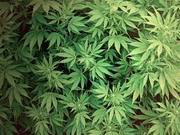

In [10]:
img = load_img(direccion_imagenes+'/190.jpg')
img

#imagenes de 180x135
# https://gianmarco.com.ar/blog/es/blog/silkroad2

####de numpy a imagen y viceversa

https://stackoverflow.com/questions/384759/how-to-convert-a-pil-image-into-a-numpy-array

In [11]:
#transforma una imagen PIL en un arreglo numpy
def pilToNumpy(img):
    return np.array(img)   # im2arr.shape: height x width x channel

# dado un arreglo en numpy grafica la imagen (grayscale o rgb) 
def graficarNumpyIm(img_numpy):
  plt.imshow(img_numpy, cmap='gray')

#dado un id de imagen devuleve su objeto PIL transformado en un objeto numpy (rgb)
def getImagen(img_id):
  return pilToNumpy(Image.open(direccion_imagenes+'/'+str(img_id)+'.jpg'))

def getImagenGray(img_id):
  return grayscale(getImagen(img_id))

#dada una imagen la transforma en un arreglo de numpy en escala de grises
def grayscale(img):
  rgb_weights = [0.2989, 0.5870, 0.1140]
  return np.dot(img, rgb_weights)

In [12]:
im = Image.open(direccion_imagenes+'/190.jpg')
testImage = pilToNumpy(im)

In [13]:
testImage.shape     #el 3 es porque es una imagen rgb

(135, 180, 3)

#####conversión de las imagenes a escala de grises

teoría conversión de rgb a grayscale
https://www.tutorialspoint.com/dip/grayscale_to_rgb_conversion.htm

de donde fué sacada la conversión
https://www.kite.com/python/answers/how-to-convert-an-image-from-rgb-to-grayscale-in-python

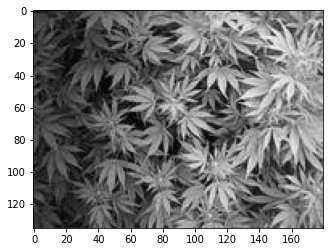

In [14]:
rgb_weights = [0.2989, 0.5870, 0.1140]    #se multiplican rojo, verde, azul por estos coeficientes y se suman
#otra formula para la conversión https://en.wikipedia.org/wiki/Grayscale  
# rgb_weights = [0.2126, 0.7152, 0.0722]

# objeto numpy
grayscale_image = np.dot(testImage, rgb_weights)
# graficar imagen
graficarNumpyIm(grayscale_image)

In [15]:
grayscale_image.shape

(135, 180)

##analisis exploratorio

https://gianmarco.com.ar/blog/es/blog/silkroad2

In [72]:
# hay misma cantidad no nula de categorías e imagenes
items[items['category'].notnull()].shape[0] == items[items['image_id'].notnull()].shape[0]

True

In [17]:
items

,item_id,title,description,vendor,price,category,timestamp,ships_from,ships_to,image_id,original_path
1,the-morality-of-capitalism,The Morality of Capitalism,\n This book has been made available to the...,echo,0.003443,Alcohol,2014-02-23T05:39:29,Undeclared,Undeclared,343.0,2014-02-24/items/the-morality-of-capitalism
2,survive,Survive!,"\n Since the dawn of time, when man first p...",echo,0.001722,Alcohol,2014-02-23T05:39:33,Undeclared,Undeclared,334.0,2014-02-24/items/survive
3,a-non-religious-new-testament,A Non-Religious New Testament,\n This is essentially the Bible written in...,echo,0.015496,Alcohol,2014-02-23T05:39:37,Undeclared,Undeclared,352.0,2014-02-24/items/a-non-religious-new-testament
4,mindless-slogans-101-cheap-substitutes-for-act...,Mindless Slogans: 101 Cheap Substitutes for Ac...,\n Think of all the stupid stuff you overhe...,echo,0.001722,Alcohol,2014-02-23T05:39:41,Undeclared,Undeclared,337.0,2014-02-24/items/mindless-slogans-101-cheap-su...
6,god-wants-you-dead,God Wants You Dead,\n FANTASTIC book for social and cultural d...,echo,0.001722,Drugs,2014-02-23T05:39:48,Undeclared,Undeclared,293.0,2014-02-24/items/god-wants-you-dead
...,...,...,...,...,...,...,...,...,...,...,...
401089,us-pharmaceuticals-deca-durabolin-300mg-ml-10m...,** US Pharmaceuticals Deca Durabolin 300mg/ml ...,\n 1 bottle of US Pharmaceuticals Deca Dura...,Bonnie & Clyde,0.125960,Anabolic Steroids,2015-01-24T17:01:31,United States,United States,6254.0,2014-04-12/items/us-pharmaceuticals-deca-durab...
401090,us-pharmaceuticals-dbol-30mg-ml-60ml-fast-ship...,** US Pharmaceuticals DBOL 30mg/ml 60ml ** Fas...,\n BACK IN STOCK!! ORDER UP!!\n\n1 bottle o...,Bonnie & Clyde,0.135366,Methandrostenolone,2015-01-24T17:01:31,United States,United States,10330.0,2014-04-12/items/us-pharmaceuticals-dbol-30mg-...
401091,us-pharmaceuticals-clomid-50mg-ml-60ml-fast-sh...,** US Pharmaceuticals Clomid 50mg/ml 60ml ** F...,\n 1 bottle of US Pharmaceuticals Clomid 50...,Bonnie & Clyde,0.109996,Steroids/PEDs,2015-01-24T17:01:31,United States,United States,10333.0,2014-04-12/items/us-pharmaceuticals-clomid-50m...
401092,trenbolone-a-100mg-ml-10ml-vails,Trenbolone A 100mg/ml 10ml Vails,\n Trenbolone Acetate\n,Roo_Juice,0.266578,Steroids/PEDs,2015-01-24T17:01:31,Australia,Australia,28450.0,2014-04-12/items/trenbolone-a-100mg-ml-10ml-vails


In [25]:
# imagenes repetidas
imgCateg = items[["image_id", "category"]]
imgCateg.nunique()

image_id    32539
category      301
dtype: int64

In [26]:
imgCateg.drop_duplicates(subset=['image_id']).nunique()

image_id    32539
category      211
dtype: int64

para una misma imagen hay categorías diferentes

In [32]:
imgCateg[imgCateg["image_id"]==343].nunique()

image_id    1
category    3
dtype: int64

es decir que la imagen 343 pertenece a la categoría Alcohol, Apparel, Books 

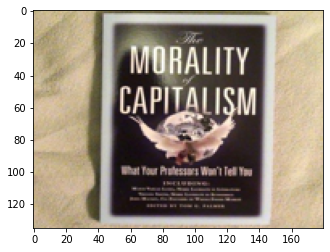

In [29]:
graficarNumpyIm(getImagen(343))

####Primer idea. En base a descripciones generar una imagen

In [56]:
items[items["description"].str.contains("book", na=False, case=False)].head(3)

,item_id,title,description,vendor,price,category,timestamp,ships_from,ships_to,image_id,original_path
1,the-morality-of-capitalism,The Morality of Capitalism,\n This book has been made available to the...,echo,0.003443,Alcohol,2014-02-23T05:39:29,Undeclared,Undeclared,343.0,2014-02-24/items/the-morality-of-capitalism
2,survive,Survive!,"\n Since the dawn of time, when man first p...",echo,0.001722,Alcohol,2014-02-23T05:39:33,Undeclared,Undeclared,334.0,2014-02-24/items/survive
4,mindless-slogans-101-cheap-substitutes-for-act...,Mindless Slogans: 101 Cheap Substitutes for Ac...,\n Think of all the stupid stuff you overhe...,echo,0.001722,Alcohol,2014-02-23T05:39:41,Undeclared,Undeclared,337.0,2014-02-24/items/mindless-slogans-101-cheap-su...


hay muchos articulos que en realidad son libros pero que tienen la categoría de alcohol. por lo tanto conviene no usar la categoría para generar las imagenes. 
* en la explicación del dataset dice que solo se pudo obtener la primer categoría del item, pero no la subcategoría más específica

como las categorias son una porquería trato de filtar los datos para generar imagenes de drogas unicamente

In [57]:
items[(items["category"]=="Drugs") & (items["description"].str.contains("book", na=False, case=False) == False)].head()

,item_id,title,description,vendor,price,category,timestamp,ships_from,ships_to,image_id,original_path
301,bulk-research-chemicals,BULK RESEARCH CHEMICALS,\n Read my vendor profile and contact me to...,TheScienceGuy,0.000000,Drugs,2014-02-23T08:37:40,China,Worldwide,2451.0,2014-02-24/items/bulk-research-chemicals
302,custom-listing-for-mc,Custom Listing for MC,\n 25g 2c-t-2 and 50g methylone for $750 (n...,TheScienceGuy,1.277828,Drugs,2014-02-23T08:37:43,China,Worldwide,3242.0,2014-02-24/items/custom-listing-for-mc
366,do-you-have-bitcoins-to-sell,Do you have BITCOINS to SELL?,"\n I will buy your bitcoins, CASH!\nIf you ...",BTCpal,0.000000,Drugs,2014-02-23T10:00:29,Undeclared,Undeclared,3392.0,2014-02-24/items/do-you-have-bitcoins-to-sell
991,50-grams-of-ketamine,50 grams of Ketamine,\n 50 grams of my fine 98%+ pure Indian sha...,haydenp,3.005410,Drugs,2014-02-23T14:44:24,United States,United States,3918.0,2014-02-24/items/50-grams-of-ketamine
992,one-ounce-28-3-grams-of-ketamine-haydenp,One ounce (28.3 grams) of Ketamine,\n 28.3 grams of my fine 98%+ pure Indian s...,haydenp,1.786721,Drugs,2014-02-23T14:44:40,United States,United States,3917.0,2014-02-24/items/one-ounce-28-3-grams-of-ketam...


aún asi es dificl de comparar con la imagen en la categoría "drogas"

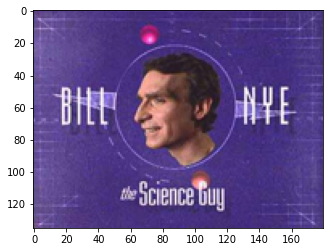

In [114]:
graficarNumpyIm(getImagen(2451))

In [58]:
with pd.option_context('display.max_colwidth', None):
  display(items[(items["category"]=="Drugs") & (items["description"].str.contains("book", na=False, case=False) == False)][["description", "image_id"]].iloc[115:116,:])

,description,image_id
7521,"\n 1 tablet of 10MG METHADONE (Methadone Hydrochloride) manufactured by Roxane Laboratories, Inc.\n\nMinimum $50 USD per shipment, you may order as many different items you like from my shop. Please select and pay for a shipment option, then select ADD TO OTHER SHIPMENT on the rest.\n",6715.0


####Segunda idea. A partir de una sola palabra

In [59]:
#en base al titulo
# items[(len(items["title"]) < 30)].iloc[30:50,:]

# items[items['title'].str.findall('\w{9,}').str.join(' ').astype(bool)]      #mayores a 9 caracteres

# items[items["title"].str.findall("(\S{4,})").astype(bool)]    #palabras?

####Tercer idea. En base a una categoría

por inventar una clasificación "Drugs" equivale a la categoría 7

El modelo final sería "generar label 7" y generará una imagen de drogas

In [ ]:
#en base a la categoría
# items[(len(items["title"]) == 1)].iloc[30:50,:]

#####cuantas categorías hay?

In [61]:
items.nunique().to_frame().T
# https://www.geeksforgeeks.org/how-to-count-distinct-values-of-a-pandas-dataframe-column/

# df.select_dtypes(exclude = ['number'])

,item_id,title,description,vendor,price,category,timestamp,ships_from,ships_to,image_id,original_path
0,32379,30263,33802,1281,237817,301,242864,59,28,32539,367673


In [62]:
#cantidad de cada categoría
items["category"].value_counts().to_frame().T

,Alcohol,Stimulants,Weed,Ecstasy,MDMA,Cannabis,Cocaine,LSD,Speed,Drug paraphernalia,Steroids/PEDs,Other,Analgesics,Anabolic Steroids,NBOMe,Benzos,Heroin,Alprazolam,Dissociatives,Drugs,Concentrates,Forgeries,2C-Family,Diazepam,DMT,Oxycodone,Opioids,Digital goods,Sildenafil Citrate,Prescription,Edibles,Shrooms,Books,Apparel,Psychedelics,Chemicals,Relaxants,Pills,Methylphenidate,Tadalafil,...,Herbal Viagra,Freebase,Herbs & Supplements,LSZ,Candy,Budder,Prozac,Suboxone,Mesterolone,Azurescens,2-DPMP,Liberty Caps,Cyanescens,DPT,Superdrol,Supplements,Snovitra,Strattera,2C-B-FLY,Stendra,Clones,Dioscorea,Aleph-2,Topicals,Co-codamol,4-HO-MPT,Anti-rheumatic,4-ACO-MIPT,Tilidine,Anti-inflammatory,5-MeO-DipT,Pethidine,AMT,Cultures,Opana,2C-D,MET,2C-T-4,4-HO-MET,Peyote
category,71133,24372,19587,17947,16013,14496,13036,10776,8622,7776,7428,6676,6239,5933,5911,5655,5273,5265,4850,4791,4413,4059,3856,3626,3539,3402,3267,3257,3256,3254,3110,2863,2840,2474,2411,2214,1752,1748,1641,1462,...,7,7,7,7,7,7,6,6,6,5,5,5,5,5,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,2,2,2,1,1,1,1,1


####cosas interesantes/divertidas del dataset

In [63]:
items[items["ships_to"]=="Argentina"]

,item_id,title,description,vendor,price,category,timestamp,ships_from,ships_to,image_id,original_path
242354,modem,modem,\n get em here\n,pentest002,0.105,Alcohol,2014-09-15T03:40:32,Austria,Argentina,48451.0,2014-09-15/items/modem


##preprocesamiento

In [18]:
#desactivar warning de una copia de una columna
pd.options.mode.chained_assignment = None  # default='warn'   

# convertir las id de las imagenes a enteros
items["image_id"] = pd.to_numeric(items["image_id"], downcast='integer')

#reducir espacio no utilizado
items = items[["image_id", "category"]]
items.head()

,image_id,category
1,343,Alcohol
2,334,Alcohol
3,352,Alcohol
4,337,Alcohol
6,293,Drugs


eliminar filas repetidas

In [20]:
items.nunique()

image_id    32539
category      301
dtype: int64

In [22]:
items.drop_duplicates(subset=['image_id']).nunique()

image_id    32539
category      211
dtype: int64

lo ideal sería saber a que categoría pertenece cada imagen realmente (¿Tarea 1?)

In [33]:
items.drop_duplicates(subset=['image_id'], inplace=True)

label encoding

In [36]:
#asignar cada categoría a un número (label encoding)
from sklearn.preprocessing import LabelEncoder
items["codigo"] = LabelEncoder().fit_transform(items['category'])
items

,image_id,category,codigo
1,343,Alcohol,25
2,334,Alcohol,25
3,352,Alcohol,25
4,337,Alcohol,25
6,293,Drugs,86
...,...,...,...
400534,32841,Alcohol,25
400541,31195,Stimulants,188
400553,32844,Alcohol,25
400773,29529,Benzos,38


quedarme solo con imagenes de cierto tamaño (180, 135)

también chequea que la imagen existe en el drive. en caso contrario la descarta

In [82]:
tamanio = (180, 135)

def tamanioUnico(imagenes, tamanio):
  candidatos = []
  for i in imagenes:
    if(Image.open(direccion_imagenes+'/'+str(i)+'.jpg').size == tamanio):    #si coincide el tamaño (y ademas existe en drive)
      candidatos.append(i)
  return imagenes

###separar train y test

In [67]:
items.head(3)

,image_id,category,codigo
1,343,Alcohol,25
2,334,Alcohol,25
3,352,Alcohol,25


In [100]:
# items[items['image_id'].isin(idIm)]["category"].value_counts().to_frame().T
items.groupby("category").head(100)["category"].value_counts().to_frame().T

,Amphetamine,Pills,NBOMe,Opioids,Anabolic Steroids,Psychedelics,Dissociatives,Heroin,Analgesics,Stimulants,Edibles,Blotter,DMT,Alcohol,Prescription,Shrooms,Alprazolam,LSD,Other,Oxycodone,Methylphenidate,2C-Family,Tadalafil,Sildenafil Citrate,Digital goods,Steroids/PEDs,Chemicals,Apparel,MDMA,Forgeries,Speed,Benzos,Cocaine,Hash,Synthetic,Relaxants,Drugs,Drug paraphernalia,Concentrates,Diazepam,...,Armodafinil,4-FA,Subaeruginose,25D-NBOMe,Budder,Erotica,Nandrolone,Trim,Scales,Packaging,2C-I,DOC,5-MAPB,Boldenone,Antibiotics,Ibogain,Masteron,Pethidine,Precursors,Co-codamol,LSZ,5-APB,Bongs,Phenazepam,Peyote,DPT,Lab Supplies,25N-NBOMe,Dianabol,Oxazepam,4-HO-MPT,Books,4-ACO-DMT,Dexamphetamine,Cultures,Proviron,Flunitrazepam,Tilidine,Digital,DOT
category,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [63]:
items[items['image_id'].isin(idIm)]["category"].value_counts().to_frame().T

,Psychedelics,Ecstasy,Other,Stimulants,DMT,Edibles,Sildenafil Citrate,Heroin
category,3,3,3,3,3,2,2,2


In [ ]:
porcentaje_split = 0.8
train = items.iloc[:int(porcentaje_split * len(df)), :]
test = items.iloc[int(porcentaje_split * len(df)):, :]

#separame en columnas, y convertilas a arreglos de numpy

##transformación en un formato que la CGAN pueda entender

In [73]:
idIm = [11, 15, 17, 19, 25, 27, 28, 32, 33, 35, 36, 38, 40, 41, 45]
idImTest = [132, 142, 150, 149, 172, 191]

In [74]:
trainX = np.array([getImagenGray(i) for i in idIm])      #https://stackoverflow.com/questions/39195113/how-to-load-multiple-images-in-a-numpy-array
trainy = np.array(idIm)
 
testX = np.array([getImagenGray(i) for i in idImTest])
testy = np.array(idImTest)

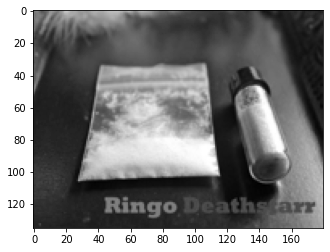

In [128]:
graficarNumpyIm(x[0])

##GAN (Baseline) o sino copiar el que se llama Unconditional


https://www.aprendemachinelearning.com/procesamiento-del-lenguaje-natural-nlp/

####explicacion

![image](https://miro.medium.com/max/700/1*i4HTOtqH4qt9zIZUN43GoA.png)

el generador lo que hace es

![image.png](https://www.tensorflow.org/tutorials/generative/images/gan2.png)

###base line, en blanco y negro

https://towardsdatascience.com/image-generation-in-10-minutes-with-generative-adversarial-networks-c2afc56bfa3b

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)
import matplotlib.pyplot as plt

In [ ]:
# underscore to omit the label arrays
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() 
train_labels[3654] = 12.23


train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() 

# len(train_images[0][0])
train_images.shape

(60000, 28, 28)

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [ ]:
generator = make_generator_model()

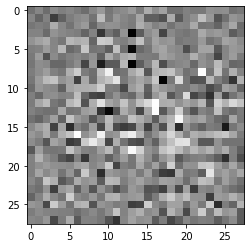

In [ ]:
# Create a random noise and generate a sample
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
# Visualize the generated sample
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()


In [ ]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00019265]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 1
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
num_examples_to_generate = 16
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# tf.function annotation causes the function 
# to be "compiled" as part of the training
@tf.function
def train_step(images):
  
    # 1 - Create a random noise to feed it into the model
    # for the image generation
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # 2 - Generate images and calculate loss values
    # GradientTape method records operations for automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # 3 - Calculate gradients using loss values and model variables
    # "gradient" method computes the gradient using 
    # operations recorded in context of this tape (gen_tape and disc_tape).
    
    # It accepts a target (e.g., gen_loss) variable and 
    # a source variable (e.g.,generator.trainable_variables)
    # target --> a list or nested structure of Tensors or Variables to be differentiated.
    # source --> a list or nested structure of Tensors or Variables.
    # target will be differentiated against elements in sources.

    # "gradient" method returns a list or nested structure of Tensors  
    # (or IndexedSlices, or None), one for each element in sources. 
    # Returned structure is the same as the structure of sources.
    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                discriminator.trainable_variables)
    
    # 4 - Process  Gradients and Run the Optimizer
    # "apply_gradients" method processes aggregated gradients. 
    # ex: optimizer.apply_gradients(zip(grads, vars))
    """
    Example use of apply_gradients:
    grads = tape.gradient(loss, vars)
    grads = tf.distribute.get_replica_context().all_reduce('sum', grads)
    # Processing aggregated gradients.
    optimizer.apply_gradients(zip(grads, vars), experimental_aggregate_gradients=False)
    """
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
import time
from IPython import display # A command shell for interactive computing in Python.

def train(dataset, epochs):
  # A. For each epoch, do the following:
  for epoch in range(epochs):
    start = time.time()
    # 1 - For each batch of the epoch, 
    for image_batch in dataset:
      # 1.a - run the custom "train_step" function
      # we just declared above
      train_step(image_batch)

    # 2 - Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 3 - Save the model every 5 epochs as 
    # a checkpoint, which we will use later
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # 4 - Print out the completed epoch no. and the time spent
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # B. Generate a final image after the training is completed
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  # 1 - Generate images
  predictions = model(test_input, training=False)
  # 2 - Plot the generated images
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  # 3 - Save the generated images
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


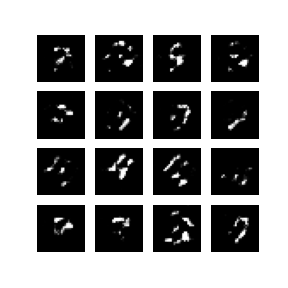

In [ ]:
# PIL is a library which may open different image file formats
import PIL 
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(EPOCHS)

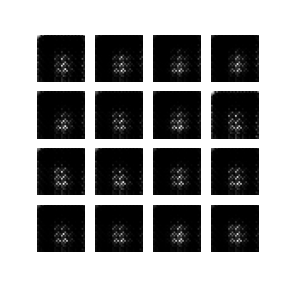

In [ ]:
import glob # The glob module is used for Unix style pathname pattern expansion.
import imageio # The library that provides an easy interface to read and write a wide range of image data

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  # image = imageio.imread(filename)
  # writer.append_data(image)
  
display.Image(open('dcgan.gif','rb').read())

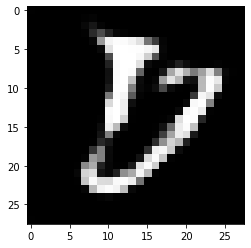

In [ ]:
# Create a random noise and generate a sample
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
# Visualize the generated sample
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

##CGAN

https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/

Generative adversarial nets can be extended to a conditional model if both the generator and discriminator are conditioned on some extra information y. […] We can perform the conditioning by feeding y into the both the discriminator and generator as additional input layer

In [16]:
# from keras.datasets.fashion_mnist import load_data
# load the images into memory
# (trainX, trainy), (testX, testy) = load_data()

We can see that there are 60K examples in the training set and 10K in the test set and that each image is a square of 28 by 28 pixels.

In [89]:
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (15, 135, 180) (15,)
Test (6, 135, 180) (6,)


In [76]:
testy

array([132, 142, 150, 149, 172, 191])

In [77]:
testX[0]

array([[ 97.7622,  97.7622,  98.7621, ..., 128.2753, 127.2754, 126.2755],
       [ 97.7622,  97.7622,  98.7621, ..., 128.2753, 127.2754, 127.2754],
       [ 97.7622,  98.7621,  99.762 , ..., 129.2752, 128.2753, 127.2754],
       ...,
       [ 88.9202,  88.9202,  88.9202, ..., 112.9178, 111.9179, 110.918 ],
       [ 87.9203,  87.9203,  88.9202, ..., 109.9181, 108.9182, 107.9183],
       [ 86.9204,  86.9204,  87.9203, ..., 108.9182, 107.9183, 107.9183]])

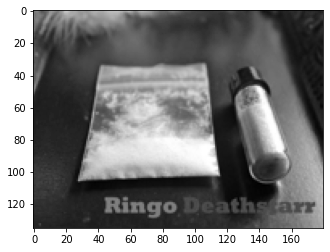

In [78]:
# plot raw pixel data
plt.imshow(trainX[0], cmap='gray')   #gray_r invierte el blanco y negro de la imagen

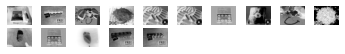

In [91]:
# plot images from the training dataset
for i in range(100):
	# define subplot
	plt.subplot(10, 10, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(trainX[i], cmap='gray_r')
plt.show()

In [95]:
base, altura = (180, 135)
base

180

In [96]:
# example of training an conditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

In [102]:
# define the standalone discriminator model
def define_discriminator(in_shape=(base,altura,1), n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
	in_image = Input(shape=in_shape)
	# concat label as a channel
	merge = Concatenate()([in_image, li])
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [103]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 7 * 7
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((7, 7, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model
 

In [104]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 

In [105]:
# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return [X, trainy]
 
# # select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y
 

In [106]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('cgan_generator.h5')

In [108]:
# size of the latent space
latent_dim = 6
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1, n_batch=100)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


ValueError: ignored

conditional


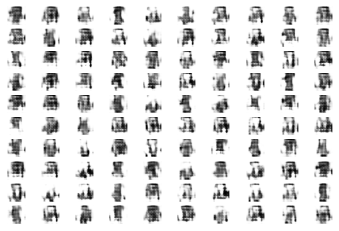

In [82]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
model = load_model('cgan_generator.h5')
# generate images
latent_points, labels = generate_latent_points(10, 100)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)